In [22]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tensorflow version: 2.19.0
pandas version: 2.2.2


In [23]:
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [24]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [25]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [26]:
def create_balanced_dataset(df):

    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [27]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [28]:
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [29]:
balanced_df.tail()

,Label,Text
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...
5567,1,This is the 2nd time we have tried 2 contact u...


In [30]:
def random_split(df,train_frac,validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    val_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df, val_df, test_df

train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
val_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [31]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [32]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.special_tokens_set)


{'<|endoftext|>'}


In [33]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, tokenizer, csv_file, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [      # Truncate sequences if they are longer than max_length
                text[:self.max_length] for text in self.encoded_texts
            ]

        self.encoded_texts = [           # pad sequences to the longest sequence
            text + [pad_token_id] * (self.max_length - len(text)) for text in self.encoded_texts
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index) :
        encoded = torch.tensor(self.encoded_texts[index])
        label = torch.tensor(self.data.iloc[index]["Label"])
        return encoded, label

    def _longest_encoded_length(self):
        return max(len(text) for text in self.encoded_texts)


In [34]:
train_dataset = SpamDataset(csv_file="train.csv", max_length=None, tokenizer=tokenizer)
print(train_dataset.max_length)

120


In [35]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [36]:
from numpy import test
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_loader = DataLoader(
    dataset= train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset= val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset= test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [37]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([5, 120])
Label batch dimensions torch.Size([5])


In [38]:
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 131
Number of batches in validation loader: 19
Number of batches in test loader: 38


In [39]:
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [40]:
!pip install import_ipynb

In [42]:
from gpt_download import download_and_load_gpt2
from GPT2ClassesFunctionsCode import GPTModel, load_weights_into_gpt

In [43]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
#just extracted 124M from CHOOSE_MODEL
settings, params = download_and_load_gpt2(model_size=model_size,models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 110kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.25MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 110kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:27<00:00, 18.2MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.53MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.92MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.87MiB/s]


In [44]:
from GPT2ClassesFunctionsCode import (generate_text_simple,
    text_to_token_ids,
    token_ids_to_text)
text_1 = "Every effort moves you"

token_ids = generate_text_simple(model=model, idx=text_to_token_ids(text_1, tokenizer),
                                 context_size=BASE_CONFIG["context_length"], max_new_tokens=30)
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.


In [45]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [46]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [47]:
for params in model.parameters():
    params.requires_grad = False

In [48]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)

In [49]:
for params in model.trf_blocks[-1].parameters():
    params.requires_grad = True

for params in model.final_norm.parameters():
    params.requires_grad = True

In [50]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs :", inputs)
print("Input shape :", inputs.shape)

Inputs : tensor([[5211,  345,  423,  640]])
Input shape : torch.Size([1, 4])


In [51]:
with torch.no_grad():
    outputs = model(inputs)
    print("Logits shape :", outputs.shape)

Logits shape : torch.Size([1, 4, 2])


In [52]:
print("Last output token:", outputs[:,-1,:])

Last output token: tensor([[-3.5983,  3.9902]])


In [53]:
probas = torch.nn.functional.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas, dim=-1)
print("Class item :", label.item())

Class item : 1


In [54]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0,0

    if num_batches is None :
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [56]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [57]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [58]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [59]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    examples_seen, global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1


            if global_step % eval_freq == 0:
                train_loss , val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)


    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [60]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [61]:
import time

start_time = time.time()

torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs = num_epochs, eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time = (end_time - start_time)/60
print(f"Training completed in {execution_time:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 46.25% | Validation accuracy: 45.00%
Ep 2 (Step 000150): Train loss 0.544, Val loss 0.478
Ep 2 (Step 000200): Train loss 0.406, Val loss 0.390
Ep 2 (Step 000250): Train loss 0.438, Val loss 0.337
Training accuracy: 46.25% | Validation accuracy: 45.00%
Ep 3 (Step 000300): Train loss 0.289, Val loss 0.369
Ep 3 (Step 000350): Train loss 0.376, Val loss 0.322
Training accuracy: 46.25% | Validation accuracy: 45.00%
Ep 4 (Step 000400): Train loss 0.145, Val loss 0.240
Ep 4 (Step 000450): Train loss 0.167, Val loss 0.144
Ep 4 (Step 000500): Train loss 0.225, Val loss 0.164
Training accuracy: 46.25% | Validation accuracy: 45.00%
Ep 5 (Step 000550): Train loss 0.212, Val loss 0.171
Ep 5 (Step 000600): Train loss 0.091, Val loss 0.076
Ep 5 (Step 000650): Train loss 0.023, Val loss 0.085
Training accuracy: 46.25% | Valida

In [63]:
import matplotlib.pyplot as plt

def plot_values(epoch_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))

    # plot training and validation loss against epochs
    ax1.plot(epoch_seen, train_values, label=f"Training {label}")
    ax1.plot(epoch_seen, val_values, label=f"Validation {label}", linestyle="--")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

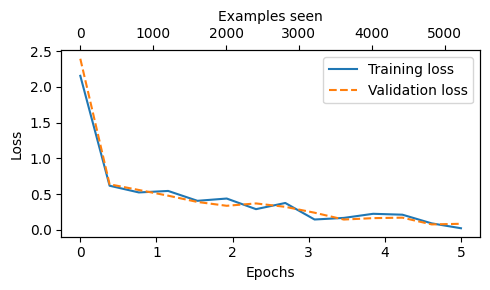

In [64]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

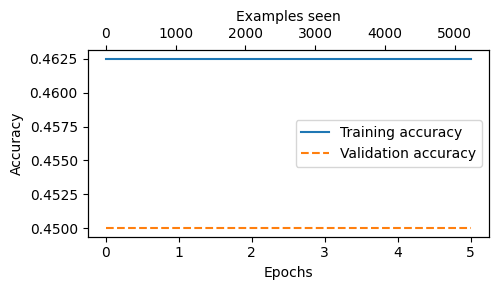

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [66]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.13%
Validation accuracy: 97.32%
Test accuracy: 96.00%


In [67]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    suppported_context_length = model.pos_emb.weight.shape[0]

    input_ids = input_ids[:min(max_length, suppported_context_length)]
    assert max_length is not None, (
         "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )

    assert max_length <= suppported_context_length, (
         f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device = device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [68]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [69]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [70]:
torch.save(model.state_dict(), "review_classifier_gpt2.pth")

In [71]:
model_state_dict = torch.load("review_classifier_gpt2.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>